In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install tensorboard_logger

!cp "/content/drive/MyDrive/DCC Codes/config.py" .
!cp "/content/drive/MyDrive/DCC Codes/edgeConstruction.py" .
!cp "/content/drive/MyDrive/DCC Codes/data_params.py" .
!cp "/content/drive/MyDrive/DCC Codes/make_data.py" .
!cp "/content/drive/MyDrive/DCC Codes/pretraining.py" .
!cp "/content/drive/MyDrive/DCC Codes/extract_feature.py" .
!cp "/content/drive/MyDrive/DCC Codes/copyGraph.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCC.py" .
!cp "/content/drive/MyDrive/DCC Codes/extractSDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/extractconvSDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/SDAE.py" .
!cp "/content/drive/MyDrive/DCC Codes/__init__.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCCComputation.py" .
!cp "/content/drive/MyDrive/DCC Codes/DCCLoss.py" .
!cp "/content/drive/MyDrive/DCC Codes/custom_data.py" .
!cp "/content/drive/MyDrive/DCC Codes/convSDAE.py" .

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from config import cfg, get_data_dir
from easydict import EasyDict as edict
from edgeConstruction import compressed_data
from custom_data import DCCPT_data
import data_params as dp
import make_data
import pretraining
import extract_feature
import copyGraph
import DCC

In [14]:
#some necessary initial functions

def set_pretraining_hypers(args):
  args.db = dp.oyster.name
  args.niter = 500
  args.step = 300
  args.lr = 0.001

# if we need to resume for faster debugging/results
  args.resume = False
  args.level = None

  args.batchsize = 300
  args.ngpu = 0
  args.deviceID = 0
  args.tensorboard = True
  args.h5 = False
  args.id = 2
  args.dim = 10
  args.manualSeed = cfg.RNG_SEED
  args.clean_log = True

def cluster_count(clusters):
  cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])
  cluster_df_count = pd.DataFrame(np.array(cluster_df['labels'].value_counts()), columns= ['labels'])
  df_filtered = cluster_df_count[cluster_df_count['labels'] >= 100]
  return len(df_filtered)

def set_training_hypers(args):
  args.batchsize = cfg.PAIRS_PER_BATCH
  args.nepoch = 150
  args.M = 10
  args.lr = 0.001

#function for finding the most frequent element in a list
def most_frequent(List):
  return max(set(List), key = List.count)

#function for deleting certain key/value pairs in a dict and returning the poped keys
def delete_dict_items(dict, val):
  poped_keys = []
  for key, value in dict.copy().items():
    if value != val:
      poped_keys.append(key)
      dict.pop(key)

  return dict, poped_keys

#function for finding the minimum value and its corresponding key in a dict
def min_value(dict):
  min_value = min(dict.values())
  for key in dict:
    if dict[key] == min_value:
      min_value_key = key
  return min_value, min_value_key


def cluster_metrics(labels, features):

    numeval = len(labels)
    dbl = metrics.davies_bouldin_score(features, labels[:numeval])
    sil = metrics.silhouette_score(features, labels[:numeval], metric='euclidean')
    ch = metrics.calinski_harabasz_score(features, labels[:numeval])

    return dbl,sil,ch

In [15]:
#oyster dataset root directory
datadir = get_data_dir(dp.oyster.name)

#shuffling the oyster dataset and making train/test sets
#X, Y = make_data.make_misc_data(datadir,'OysterMetro_Complete_Small_Sample_Feature_Extracted.csv',dim= 10)

#oyster dataset shape (whole data)
#N = X.shape[0]
N = 12617
#defining a super dict for storing clusters, cluster counts, and dbl for each eligible k
super_dict = dict()

In [ ]:
#here we begin the algorithm with the chosen range of k
for k in range(1,11):
  print('starting model with k=', k)
  #construct the mkNN graph
  compressed_data(dp.oyster.name, N, k, preprocess='none', algo='knn', isPCA=None, format='mat')

  #creating hyperparameter dict
  args = edict()

  #setting some pretraining hyperparameters
  set_pretraining_hypers(args)
  args.k = k

  #initializing net for pretraining
  index = len(dp.oyster.dim) - 1
  net = None

  #start pretraining
  index, net = pretraining.main(args)
  print(index)

  # extracting pretrained features
  args.feat = 'pretrained'
  args.torchmodel = 'checkpoint_{}.pth.tar'.format(index)
  print('Extracted features:')
  print(extract_feature.main(args, net=net))

  # merging the features and mkNN graph
  args.g = 'pretrained.mat'
  args.out = 'pretrained'
  args.feat = 'pretrained.pkl'
  print('Merged features:')
  print(copyGraph.main(args))

  #defining necessary dicts for model selection and overfitting detection
  cluster_dict = dict()
  cluster_count_dict = dict()
  dbl_dict = dict()

#PHASE 1: starting the overfitting detection phase
  #setting some training hyperparameters
  set_training_hypers(args)

  #start training for 10 epochs, then detect overfitting
  clusters, dbl = DCC.main(args, net=net)
  if cluster_count(clusters) == 1 or cluster_count(clusters) == 2:
    print(cluster_count(clusters))
    print('Overfitting Detected!')
    continue
  else:
    print('Phase 1 done!')
    cluster_dict[10] = clusters
    cluster_count_dict[10] = cluster_count(clusters)
    dbl_dict[10] = dbl

#PHASE 2: starting the model selection phase
    #setting some hyperparameters to continue training
    args.resume = True
    epoch_list = [20,30,40,50]

    #continue training until 50 epochs
    for epoch in epoch_list:
      args.level = epoch - 10
      clusters, dbl = DCC.main(args, net=net)
      print('done with epoch ', epoch)
      cluster_dict[epoch] = clusters
      cluster_count_dict[epoch] = cluster_count(clusters)
      dbl_dict[epoch] = dbl

    #storing the three dicts in the super dict for further evaluation
    super_dict[k] = [cluster_dict, cluster_count_dict, dbl_dict]
    print('done algorithm on model with k= ', k)

Streaming output truncated to the last 5000 lines.
reconstruction_loss:  0.0019266849941822041 epoch:  53
dcc_loss:  8.058578496155207e-08 epoch:  53

 Epoch: 54
total_loss:  0.0019222684897059205 epoch:  54
reconstruction_loss:  0.0019221757243390004 epoch:  54
dcc_loss:  9.275929347975916e-08 epoch:  54

 Epoch: 55
total_loss:  0.001924679596501897 epoch:  55
reconstruction_loss:  0.001924581417557547 epoch:  55
dcc_loss:  9.817536426622337e-08 epoch:  55

 Epoch: 56
total_loss:  0.0019290212618469208 epoch:  56
reconstruction_loss:  0.0019289226033947378 epoch:  56
dcc_loss:  9.865513254605053e-08 epoch:  56

 Epoch: 57
total_loss:  0.001928391545343143 epoch:  57
reconstruction_loss:  0.0019283042627012354 epoch:  57
dcc_loss:  8.728522954597179e-08 epoch:  57

 Epoch: 58
total_loss:  0.0019278689758266837 epoch:  58
reconstruction_loss:  0.0019277768920542388 epoch:  58
dcc_loss:  9.20821337048673e-08 epoch:  58

 Epoch: 59
total_loss:  0.0019327398030835879 epoch:  59
reconstruct

In [ ]:
super_dict

{1: [{10: array([   0,    1,    2, ..., 2900,   32,  405], dtype=int32),
   20: array([   0,    1,    2, ..., 2904,   32,  405], dtype=int32),
   30: array([   0,    1,    2, ..., 2899,   32,  405], dtype=int32),
   40: array([   0,    1,    2, ..., 2898, 3141,  405], dtype=int32),
   50: array([   0,    1,    2, ..., 2893,   32,  405], dtype=int32)},
  {10: 0, 20: 0, 30: 0, 40: 0, 50: 0},
  {10: 1.1996335108553022,
   20: 1.2004053770909924,
   30: 1.201415494302528,
   40: 1.2018492770491007,
   50: 1.202470844949093}],
 2: [{10: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   20: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   30: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   40: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   50: array([0, 1, 2, ..., 4, 2, 5], dtype=int32)},
  {10: 7, 20: 7, 30: 7, 40: 7, 50: 8},
  {10: 1.1741136074416196,
   20: 1.011441362886694,
   30: 0.9653846680747988,
   40: 0.9414760642535108,
   50: 0.9621817923307759}],
 3: [{10: array([0, 1, 2, ..., 4,

In [ ]:
#here we begin the algorithm with the optimal k
super_dict = dict()
for k in range(3,4):
  print('starting model with k=', k)
  #construct the mkNN graph
  compressed_data(dp.oyster.name, N, k, preprocess='none', algo='knn', isPCA=None, format='mat')

  #creating hyperparameter dict
  args = edict()

  #setting some pretraining hyperparameters
  set_pretraining_hypers(args)
  args.k = k

  #initializing net for pretraining
  index = len(dp.oyster.dim) - 1
  net = None

  #start pretraining
  index, net = pretraining.main(args)
  print(index)

  # extracting pretrained features
  args.feat = 'pretrained'
  args.torchmodel = 'checkpoint_{}.pth.tar'.format(index)
  print('Extracted features:')
  print(extract_feature.main(args, net=net))

  # merging the features and mkNN graph
  args.g = 'pretrained.mat'
  args.out = 'pretrained'
  args.feat = 'pretrained.pkl'
  print('Merged features:')
  print(copyGraph.main(args))

  #defining necessary dicts for model selection and overfitting detection
  cluster_dict = dict()
  cluster_count_dict = dict()
  dbl_dict = dict()

#PHASE 1: starting the overfitting detection phase
  #setting some training hyperparameters
  set_training_hypers(args)

  #start training for 10 epochs, then detect overfitting
  clusters, dbl = DCC.main(args, net=net)
  if cluster_count(clusters) == 1 or cluster_count(clusters) == 2:
    print(cluster_count(clusters))
    print('Overfitting Detected!')
    continue
  else:
    print('Phase 1 done!')
    cluster_dict[10] = clusters
    cluster_count_dict[10] = cluster_count(clusters)
    dbl_dict[10] = dbl

#PHASE 2: starting the model selection phase
    #setting some hyperparameters to continue training
    args.resume = True
    epoch_list = [20,30,40,50]

    #continue training until 50 epochs
    for epoch in epoch_list:
      args.level = epoch - 10
      clusters, dbl = DCC.main(args, net=net)
      print('done with epoch ', epoch)
      cluster_dict[epoch] = clusters
      cluster_count_dict[epoch] = cluster_count(clusters)
      dbl_dict[epoch] = dbl

    #storing the three dicts in the super dict for further evaluation
    super_dict[k] = [cluster_dict, cluster_count_dict, dbl_dict]
    print('done algorithm on model with k= ', k)

starting model with k= 3
No preprocessing is applied
The time taken for edge set computation is 7.9475414752960205

Index: 0 	 Maxepoch: 15

Index: 0 	 Epoch: 0
train_loss_0 0.24576258703802004 0
val_loss_0 0.21883120601509717 0

Index: 0 	 Epoch: 1
train_loss_0 0.19600205022292108 1
val_loss_0 0.17269072012175848 1

Index: 0 	 Epoch: 2
train_loss_0 0.1554943377333496 2
val_loss_0 0.13799264989261958 2

Index: 0 	 Epoch: 3
train_loss_0 0.12519030518262153 3
val_loss_0 0.1120413373535862 3

Index: 0 	 Epoch: 4
train_loss_0 0.10254434946978705 4
val_loss_0 0.0926750861167341 4

Index: 0 	 Epoch: 5
train_loss_0 0.0856447552308554 5
val_loss_0 0.07828296279378247 5

Index: 0 	 Epoch: 6
train_loss_0 0.07311472725752477 6
val_loss_0 0.06764669985570923 6

Index: 0 	 Epoch: 7
train_loss_0 0.06392461715848727 7
val_loss_0 0.0598700745075516 7

Index: 0 	 Epoch: 8
train_loss_0 0.059752805052749776 8
val_loss_0 0.05923634948778644 8

Index: 0 	 Epoch: 9
train_loss_0 0.05913032433295833 9
val_los

In [ ]:
super_dict

{3: [{10: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   20: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   30: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   40: array([0, 1, 2, ..., 4, 2, 5], dtype=int32),
   50: array([0, 1, 2, ..., 4, 2, 5], dtype=int32)},
  {10: 7, 20: 7, 30: 7, 40: 7, 50: 7},
  {10: 0.9994927461794473,
   20: 1.089370410366723,
   30: 1.3239781003614846,
   40: 1.136764471898368,
   50: 1.2600199873073143}]}

In [ ]:
#PHASE 3: final model selection(k value) based on lowest dbl
#parameter for the real number of clusters
gtcluster_count = None

#looping through the cluster count dicts in super dict,
#and setting the real number of clusters based on majority voting
final_cluster_list = []

#adding all possible cluster counts to a list
for key in super_dict.keys():
  for value in super_dict[key][1].values():
    final_cluster_list.append(value)

#finding most frequent count in list a.k.a majority voting
gtcluster_count = most_frequent(final_cluster_list)

#looping through the cluster dict and dbl dict in super dict,
#and deleting records if cluster count is not the optimum value determined
for key in super_dict.keys():
  super_dict[key][1], poped_keys= delete_dict_items(super_dict[key][1], gtcluster_count)
  for element in poped_keys:
    super_dict[key][0].pop(element)
    super_dict[key][2].pop(element)

#looping through the dbl dicts, and finding the k with the lowest dbl value
min_dbl = 100
min_dbl_key = 0
optimal_k = 100

for key in super_dict.keys():
  if super_dict[key][2] == {}:
    continue
  else:
    dict_min_dbl, dict_min_dbl_key = min_value(super_dict[key][2])
    if dict_min_dbl < min_dbl:
      min_dbl = dict_min_dbl
      min_dbl_key = dict_min_dbl_key
      optimal_k = key

#selecting the final 3 dicts for optimum k
final_dict = super_dict[optimal_k]

In [ ]:
#PHASE 4:in this section we will continue the algorithm
#for more epochs with the optimum k if the minimum DBL
#happens on epoch 50 and there is a lower minimum possibility
if min_dbl_key == 50:
  epoch = 60
  args.k = optimal_k
  args.resume = True

  while True:
    if epoch == 100: break
    args.level = epoch - 10
    clusters, dbl = DCC.main(args, net=net)
    print('done with epoch ', epoch)
    if dbl > min_dbl:
      print('minimum dbl unchanged. Terminating algorithm.')
      break
    else:
      min_dbl = dbl

      cluster_dict[epoch] = clusters
      cluster_count_dict[epoch] = cluster_count(clusters)
      dbl_dict[epoch] = dbl
      epoch += 10

In [ ]:
optimal_k = 3
min_dbl_key = 50
min_dbl = 1.2600199873073143

In [ ]:
epoch = 60
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
min_dbl = dbl
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_50.pth.tar'

 Epoch: 60
total_loss:  0.0019264257699530905 epoch:  60
reconstruction_loss:  0.0019263058301819808 epoch:  60
dcc_loss:  1.199388527125323e-07 epoch:  60
epoch:  60 DBL:  1.21619055079378

 Epoch: 61
total_loss:  0.001927250252600939 epoch:  61
reconstruction_loss:  0.001927144180071236 epoch:  61
dcc_loss:  1.060675624620153e-07 epoch:  61

 Epoch: 62
total_loss:  0.001923763994885614 epoch:  62
reconstruction_loss:  0.0019236622650971192 epoch:  62
dcc_loss:  1.0173158837558929e-07 epoch:  62

 Epoch: 63
total_loss:  0.001921296674925338 epoch:  63
reconstruction_loss:  0.0019212047132348491 epoch:  63
dcc_loss:  9.195837020432973e-08 epoch:  63

 Epoch: 64
total_loss:  0.0019199928689774366 epoch:  64
reconstruction_loss:  0.0019198844494291425 epoch:  64
dcc_loss:  1.0841821949672106e-07 ep

In [ ]:
epoch = 70
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_60.pth.tar'

 Epoch: 70
total_loss:  0.0019249947158742492 epoch:  70
reconstruction_loss:  0.0019248849337300598 epoch:  70
dcc_loss:  1.0978288788621371e-07 epoch:  70
epoch:  70 DBL:  1.21619055079378

 Epoch: 71
total_loss:  0.0019240222975064614 epoch:  71
reconstruction_loss:  0.0019238954848167487 epoch:  71
dcc_loss:  1.268093796183094e-07 epoch:  71

 Epoch: 72
total_loss:  0.0019220295846823301 epoch:  72
reconstruction_loss:  0.001921908951225245 epoch:  72
dcc_loss:  1.2063685284384148e-07 epoch:  72

 Epoch: 73
total_loss:  0.0019197866417021707 epoch:  73
reconstruction_loss:  0.0019196971668837776 epoch:  73
dcc_loss:  8.948134400848062e-08 epoch:  73

 Epoch: 74
total_loss:  0.0019192898580757112 epoch:  74
reconstruction_loss:  0.0019191791780754936 epoch:  74
dcc_loss:  1.1067570886293143e-0

In [ ]:
epoch = 80
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_70.pth.tar'

 Epoch: 80
total_loss:  0.00192219196990846 epoch:  80
reconstruction_loss:  0.0019220808568510754 epoch:  80
dcc_loss:  1.1110792633985928e-07 epoch:  80
epoch:  80 DBL:  1.21619055079378

 Epoch: 81
total_loss:  0.0019233854192518387 epoch:  81
reconstruction_loss:  0.001923262080834961 epoch:  81
dcc_loss:  1.2333053570755567e-07 epoch:  81

 Epoch: 82
total_loss:  0.0019221707674447015 epoch:  82
reconstruction_loss:  0.0019220310739845121 epoch:  82
dcc_loss:  1.3969309114431027e-07 epoch:  82

 Epoch: 83
total_loss:  0.0019195680520442825 epoch:  83
reconstruction_loss:  0.001919455748526652 epoch:  83
dcc_loss:  1.123009751781668e-07 epoch:  83

 Epoch: 84
total_loss:  0.001917336432203039 epoch:  84
reconstruction_loss:  0.0019172057692879586 epoch:  84
dcc_loss:  1.3065834497539577e-07 e

In [ ]:
epoch = 90
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_80.pth.tar'

 Epoch: 90
total_loss:  0.0019198747206743655 epoch:  90
reconstruction_loss:  0.0019197332739734909 epoch:  90
dcc_loss:  1.4144814742312487e-07 epoch:  90
epoch:  90 DBL:  1.21619055079378

 Epoch: 91
total_loss:  0.0019207905368002064 epoch:  91
reconstruction_loss:  0.001920663890821554 epoch:  91
dcc_loss:  1.2664554485447675e-07 epoch:  91

 Epoch: 92
total_loss:  0.0019180486252940378 epoch:  92
reconstruction_loss:  0.0019179162728037795 epoch:  92
dcc_loss:  1.3235485265178139e-07 epoch:  92

 Epoch: 93
total_loss:  0.0019194398038567947 epoch:  93
reconstruction_loss:  0.0019193248879401084 epoch:  93
dcc_loss:  1.1492134712305674e-07 epoch:  93

 Epoch: 94
total_loss:  0.0019160713395266322 epoch:  94
reconstruction_loss:  0.0019159358072480782 epoch:  94
dcc_loss:  1.355342584244624e-

In [ ]:
epoch = 100
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_90.pth.tar'

 Epoch: 100
total_loss:  0.0019206307291106384 epoch:  100
reconstruction_loss:  0.001920487888666824 epoch:  100
dcc_loss:  1.4283621378884245e-07 epoch:  100
epoch:  100 DBL:  1.21619055079378

 Epoch: 101
total_loss:  0.001919022392903832 epoch:  101
reconstruction_loss:  0.001918900190538038 epoch:  101
dcc_loss:  1.221993763287536e-07 epoch:  101

 Epoch: 102
total_loss:  0.0019147907765753119 epoch:  102
reconstruction_loss:  0.0019146636313748166 epoch:  102
dcc_loss:  1.2714785871878772e-07 epoch:  102

 Epoch: 103
total_loss:  0.0019166043692819227 epoch:  103
reconstruction_loss:  0.0019164947195119662 epoch:  103
dcc_loss:  1.0965114781403187e-07 epoch:  103

 Epoch: 104
total_loss:  0.0019126872641353346 epoch:  104
reconstruction_loss:  0.0019125605960086261 epoch:  104
dcc_loss:  1.

In [ ]:
epoch = 110
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_100.pth.tar'

 Epoch: 110
total_loss:  0.0019204683421168813 epoch:  110
reconstruction_loss:  0.0019202856308786205 epoch:  110
dcc_loss:  1.8271125658160927e-07 epoch:  110
epoch:  110 DBL:  1.1391691239931916

 Epoch: 111
total_loss:  0.0019190586210297805 epoch:  111
reconstruction_loss:  0.0019188945488334316 epoch:  111
dcc_loss:  1.6407531648616885e-07 epoch:  111

 Epoch: 112
total_loss:  0.0019127492761045917 epoch:  112
reconstruction_loss:  0.0019126041064538577 epoch:  112
dcc_loss:  1.451679825785293e-07 epoch:  112

 Epoch: 113
total_loss:  0.0019144054114701588 epoch:  113
reconstruction_loss:  0.00191426865064901 epoch:  113
dcc_loss:  1.3676075343193423e-07 epoch:  113

 Epoch: 114
total_loss:  0.0019100030141357657 epoch:  114
reconstruction_loss:  0.0019098750291946525 epoch:  114
dcc_loss:

In [ ]:
epoch = 120
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_110.pth.tar'

 Epoch: 120
total_loss:  0.00191616616179925 epoch:  120
reconstruction_loss:  0.001915997223817903 epoch:  120
dcc_loss:  1.6893988284487537e-07 epoch:  120
epoch:  120 DBL:  1.1514512809719037

 Epoch: 121
total_loss:  0.0019130005758794645 epoch:  121
reconstruction_loss:  0.001912841762684128 epoch:  121
dcc_loss:  1.5881278053866624e-07 epoch:  121

 Epoch: 122
total_loss:  0.0019089807595183406 epoch:  122
reconstruction_loss:  0.0019088329183225253 epoch:  122
dcc_loss:  1.478348669097537e-07 epoch:  122

 Epoch: 123
total_loss:  0.0019106086145801453 epoch:  123
reconstruction_loss:  0.0019104793650823913 epoch:  123
dcc_loss:  1.292488917208334e-07 epoch:  123

 Epoch: 124
total_loss:  0.001909131806900417 epoch:  124
reconstruction_loss:  0.0019089738741008358 epoch:  124
dcc_loss:  1.

In [ ]:
epoch = 130
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_120.pth.tar'

 Epoch: 130
total_loss:  0.0019138582635586806 epoch:  130
reconstruction_loss:  0.0019136129538415854 epoch:  130
dcc_loss:  2.453083906601732e-07 epoch:  130
epoch:  130 DBL:  1.1213212946737672

 Epoch: 131
total_loss:  0.00190979189194395 epoch:  131
reconstruction_loss:  0.0019095711519267096 epoch:  131
dcc_loss:  2.2074544987885129e-07 epoch:  131

 Epoch: 132
total_loss:  0.0019070590140290774 epoch:  132
reconstruction_loss:  0.0019068561877482056 epoch:  132
dcc_loss:  2.0282524600634622e-07 epoch:  132

 Epoch: 133
total_loss:  0.001904602794773176 epoch:  133
reconstruction_loss:  0.0019044149220661386 epoch:  133
dcc_loss:  1.8787327155010376e-07 epoch:  133

 Epoch: 134
total_loss:  0.0019024958828058435 epoch:  134
reconstruction_loss:  0.0019022881734296632 epoch:  134
dcc_loss: 

In [ ]:
epoch = 140
args.k = optimal_k
args.resume = True
args.level = epoch - 10
clusters, dbl = DCC.main(args, net=net)
print('done with epoch ', epoch)
print(cluster_count(clusters))


 Loaded `oyster` dataset for finetuning
The endpoints are Delta1: 0.000, Delta2: 0.005
==> loading checkpoint '/content/drive/MyDrive/DCC-master/data/oyster/results//FTcheckpoint_130.pth.tar'

 Epoch: 140
total_loss:  0.0019011768399989882 epoch:  140
reconstruction_loss:  0.0019008703807727977 epoch:  140
dcc_loss:  3.0645913210402293e-07 epoch:  140
epoch:  140 DBL:  0.9161833113098152

 Epoch: 141
total_loss:  0.001895470653602555 epoch:  141
reconstruction_loss:  0.0018952161036156889 epoch:  141
dcc_loss:  2.545478166190841e-07 epoch:  141

 Epoch: 142
total_loss:  0.0018967328687648603 epoch:  142
reconstruction_loss:  0.0018964175851782486 epoch:  142
dcc_loss:  3.152837707409993e-07 epoch:  142

 Epoch: 143
total_loss:  0.0018957006654234238 epoch:  143
reconstruction_loss:  0.0018953783192419008 epoch:  143
dcc_loss:  3.2234581033250116e-07 epoch:  143

 Epoch: 144
total_loss:  0.0018868928139134703 epoch:  144
reconstruction_loss:  0.0018865089658727983 epoch:  144
dcc_loss:

In [ ]:
DBL_values = [1.17,0.99,1.11,1.10,1.03,1.04,0.94,0.98,0.98]
k_values = [2,3,4,5,6,7,8,9,10]
cluster_numbers = [7,7,3,3,7,2,8,1,1]

DBL_values_2 = [0.99,1.08,1.32,1.36,1.26,1.21,1.21,1.21,1.21,1.21,1.13,1.15,1.12,0.91,0.91]
epoch_values = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150]
cluster_numbers_2 = [7,7,7,7,7,7,7,7,7,7,7,7,7,1,1]


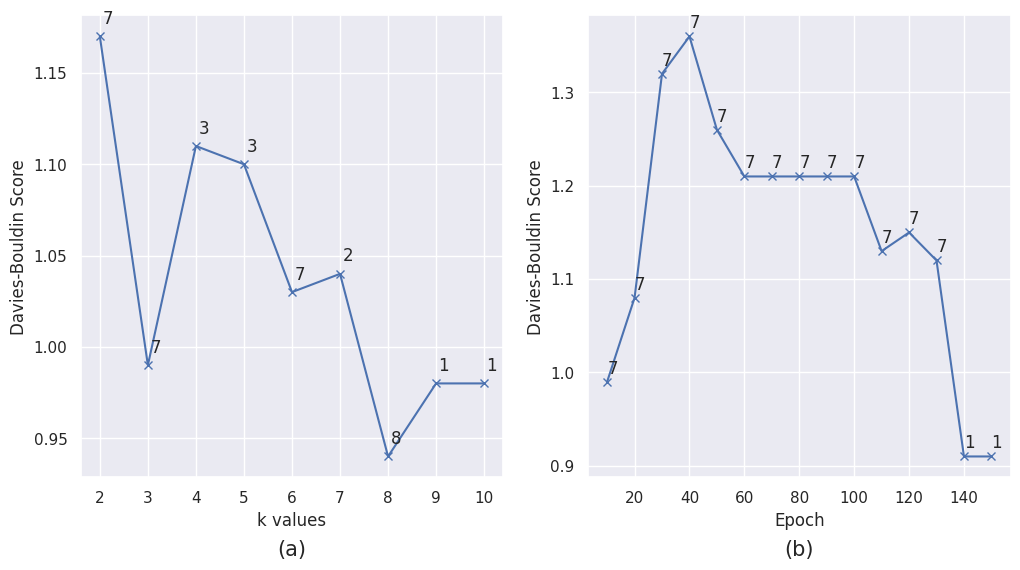

In [ ]:
figure, axis = plt.subplots(1,2, figsize= (12,6))

axis[0].plot(k_values, DBL_values, 'bx-')
axis[0].set_xlabel('k values')
axis[0].set_ylabel('Davies-Bouldin Score')
axis[0].text(0.5,-0.17, "(a)", size=15, ha="center", transform=axis[0].transAxes)
for i, txt in enumerate(cluster_numbers):
  axis[0].annotate(txt, (k_values[i], DBL_values[i]), xytext= (k_values[i] + 0.05, DBL_values[i] + 0.007))

#axis[1].plot(k_values, cluster_numbers, 'bx-')
#axis[1].set_xlabel('k values')
#axis[1].set_ylabel('Number of clusters')
#axis[1].text(0.5,-0.17, "(b)", size=15, ha="center", transform=axis[1].transAxes)

axis[1].plot(epoch_values, DBL_values_2, 'bx-')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Davies-Bouldin Score')
axis[1].text(0.5,-0.17, "(b)", size=15, ha="center", transform=axis[1].transAxes)
for i, txt in enumerate(cluster_numbers_2):
  axis[1].annotate(txt, (epoch_values[i], DBL_values_2[i]), xytext= (epoch_values[i] + 0.015, DBL_values_2[i] + 0.009))

#axis[1].plot(epoch_values, cluster_numbers_2, 'bx-')
#axis[1].set_xlabel('Epoch')
#axis[1].set_ylabel('Number of clusters')
#axis[1].text(0.5,-0.17, "(b)", size=15, ha="center", transform=axis[1].transAxes)

plt.show()

In [16]:
cluster_feature_dict = loadmat('/content/drive/MyDrive/DCC-master/data/oyster/results/3/features')
clusters = cluster_feature_dict.get('cluster')
cluster_df = pd.DataFrame(clusters.T, columns= ['labels'])
np.array(cluster_df['labels'].value_counts())

array([2305, 2159, 2123, 2103, 2086, 1109,  645,   16,   14,    9,    8,
          5,    4,    4,    4,    2,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1])

In [17]:
cluster_df.loc[(cluster_df['labels'] == 6), 'labels'] = 'temp'
cluster_df.loc[(cluster_df['labels'] == 7), 'labels'] = 6
cluster_df.loc[(cluster_df['labels'] == 'temp'), 'labels'] = 7
cluster_df['labels'].value_counts().head(30)

labels
3     2305
5     2159
2     2123
1     2103
4     2086
7     1109
0      645
13      16
12      14
10       9
14       8
15       5
18       4
11       4
6        4
23       2
26       1
35       1
34       1
33       1
32       1
31       1
30       1
29       1
28       1
27       1
25       1
9        1
24       1
22       1
Name: count, dtype: int64

In [18]:
embeddings = cluster_feature_dict.get('U')
embeddings_df = pd.DataFrame(embeddings, columns= ['0','1'])
embeddings_df['y'] = cluster_df['labels']
embeddings_df.head()

,0,1,y
0,0.022361,0.024975,0
1,0.097149,0.098415,1
2,-0.084428,-0.086610,2
3,-0.148252,-0.150514,3
4,0.053110,0.057971,4


In [19]:
cluster_df.loc[(cluster_df['labels'] != 0)
                      & (cluster_df['labels'] != 1)
                      & (cluster_df['labels'] != 2)
                      & (cluster_df['labels'] != 3)
                      & (cluster_df['labels'] != 4)
                      & (cluster_df['labels'] != 5)
                      & (cluster_df['labels'] != 6), 'labels'] = 7

cluster_df['labels'].value_counts().head(30)

labels
3    2305
5    2159
2    2123
1    2103
4    2086
7    1192
0     645
6       4
Name: count, dtype: int64

In [20]:
embeddings_df.loc[(embeddings_df['y'] != 0)
                      & (embeddings_df['y'] != 1)
                      & (embeddings_df['y'] != 2)
                      & (embeddings_df['y'] != 3)
                      & (embeddings_df['y'] != 4)
                      & (embeddings_df['y'] != 5)
                      & (embeddings_df['y'] != 6), 'y'] = 7

embeddings_df['y'].value_counts().head(30)

y
3    2305
5    2159
2    2123
1    2103
4    2086
7    1192
0     645
6       4
Name: count, dtype: int64

In [21]:
args = edict()
args.db = dp.oyster.name
args.h5 = False

trainset = DCCPT_data(root=datadir, train=True, h5=args.h5)
testset = DCCPT_data(root=datadir, train=False, h5=args.h5)
totalset = torch.utils.data.ConcatDataset([trainset, testset])

data_loader = DataLoader(totalset, batch_size=len(totalset))
data_loader_array = next(iter(data_loader))[0].numpy()

oyster = pd.DataFrame(data_loader_array)

oyster['y'] = cluster_df['labels']
clean_oyster = oyster[oyster['y']!= 7]
clean_oyster['y'].value_counts().head(30)

y
3    2305
5    2159
2    2123
1    2103
4    2086
0     645
6       4
Name: count, dtype: int64

In [22]:
clean_oyster

,0,1,2,3,4,5,6,7,8,9,y
0,0.525365,0.518912,0.624645,0.668442,0.524852,0.479865,0.290598,0.182024,0.900969,0.801938,0
1,0.747047,0.717983,0.608954,0.454633,0.624026,0.482914,0.128205,0.039828,0.722521,0.000000,1
2,0.534399,0.520239,0.318055,0.657654,0.155683,0.568176,0.196581,0.189481,0.099031,0.801938,2
3,0.851286,0.828135,0.543504,0.460301,0.484694,0.716102,0.264957,0.214564,0.000000,0.356896,3
4,0.746352,0.719973,0.608954,0.454622,0.541831,0.432205,0.162393,0.070166,1.000000,0.356896,4
...,...,...,...,...,...,...,...,...,...,...,...
12612,0.732453,0.728600,0.527265,0.421173,0.300796,0.617684,0.444444,0.323880,0.722521,0.000000,1
12613,0.437109,0.427339,0.575869,0.340688,0.524852,0.479865,0.196581,0.139484,0.277479,0.000000,5
12614,0.874218,0.851360,0.566812,0.461796,0.729240,0.526955,0.282051,0.182532,1.000000,0.356896,4
12615,0.268937,0.271400,0.576957,0.000000,0.541831,0.432205,0.256410,0.359267,0.099031,0.801938,2


In [23]:
embeddings_df = embeddings_df[embeddings_df['y']!= 7]
embeddings_df['y'].value_counts().head(30)

y
3    2305
5    2159
2    2123
1    2103
4    2086
0     645
6       4
Name: count, dtype: int64

In [24]:
embeddings_df

,0,1,y
0,0.022361,0.024975,0
1,0.097149,0.098415,1
2,-0.084428,-0.086610,2
3,-0.148252,-0.150514,3
4,0.053110,0.057971,4
...,...,...,...
12612,0.092828,0.095020,1
12613,-0.219784,-0.220484,5
12614,0.047497,0.052438,4
12615,-0.094250,-0.096352,2


In [25]:
labels = clean_oyster['y']
clean_oyster.drop(['y'], axis= 1, inplace= True)
embeddings_df.drop(['y'], axis= 1, inplace= True)
DCC_dbl, DCC_sil, DCC_ch = cluster_metrics(labels, embeddings_df)

In [26]:
DCC_dbl, DCC_sil, DCC_ch

(0.33872836964502817, 0.71580803, 253173.03375719182)

In [27]:
# pca = PCA(n_components=2)
# pca_results = pca.fit_transform(clean_oyster.values)

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(clean_oyster.values)

In [28]:
X = clean_oyster.copy()
X['DCC Patterns'] = labels

X['dcc-2d-one'] = embeddings_df['0']
X['dcc-2d-two'] = embeddings_df['1']

# X['pca-2d-one'] = pca_results[:,0]
# X['pca-2d-two'] = pca_results[:,1]

X['tsne-2d-one'] = tsne_results[:,0]
X['tsne-2d-two'] = tsne_results[:,1]
X

,0,1,2,3,4,5,6,7,8,9,DCC Patterns,dcc-2d-one,dcc-2d-two,tsne-2d-one,tsne-2d-two
0,0.525365,0.518912,0.624645,0.668442,0.524852,0.479865,0.290598,0.182024,0.900969,0.801938,0,0.022361,0.024975,14.068683,73.951477
1,0.747047,0.717983,0.608954,0.454633,0.624026,0.482914,0.128205,0.039828,0.722521,0.000000,1,0.097149,0.098415,65.812729,-15.512911
2,0.534399,0.520239,0.318055,0.657654,0.155683,0.568176,0.196581,0.189481,0.099031,0.801938,2,-0.084428,-0.086610,-36.045578,30.727270
3,0.851286,0.828135,0.543504,0.460301,0.484694,0.716102,0.264957,0.214564,0.000000,0.356896,3,-0.148252,-0.150514,-53.647953,8.616167
4,0.746352,0.719973,0.608954,0.454622,0.541831,0.432205,0.162393,0.070166,1.000000,0.356896,4,0.053110,0.057971,27.732677,47.956223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12612,0.732453,0.728600,0.527265,0.421173,0.300796,0.617684,0.444444,0.323880,0.722521,0.000000,1,0.092828,0.095020,35.979401,-3.319219
12613,0.437109,0.427339,0.575869,0.340688,0.524852,0.479865,0.196581,0.139484,0.277479,0.000000,5,-0.219784,-0.220484,3.633168,-79.805496
12614,0.874218,0.851360,0.566812,0.461796,0.729240,0.526955,0.282051,0.182532,1.000000,0.356896,4,0.047497,0.052438,20.765091,43.245045
12615,0.268937,0.271400,0.576957,0.000000,0.541831,0.432205,0.256410,0.359267,0.099031,0.801938,2,-0.094250,-0.096352,-22.461691,28.769867


In [29]:
oyster_features = clean_oyster.values

In [30]:
distortions = []
inertias = []
km_silhouette = []
db_score = []
ch_score = []
mapping = {}
K = range(2,11)

for k in K:
    #Building and fitting the model
    km = KMeans(n_clusters=k).fit(oyster_features)
    preds = km.predict(oyster_features)

    inertias.append(km.inertia_)

    mapping[k] = km.inertia_

    silhouette = metrics.silhouette_score(oyster_features,preds)
    km_silhouette.append(silhouette)

    db = metrics.davies_bouldin_score(oyster_features,preds)
    db_score.append(db)

    ch = metrics.calinski_harabasz_score(oyster_features,preds)
    ch_score.append(ch)

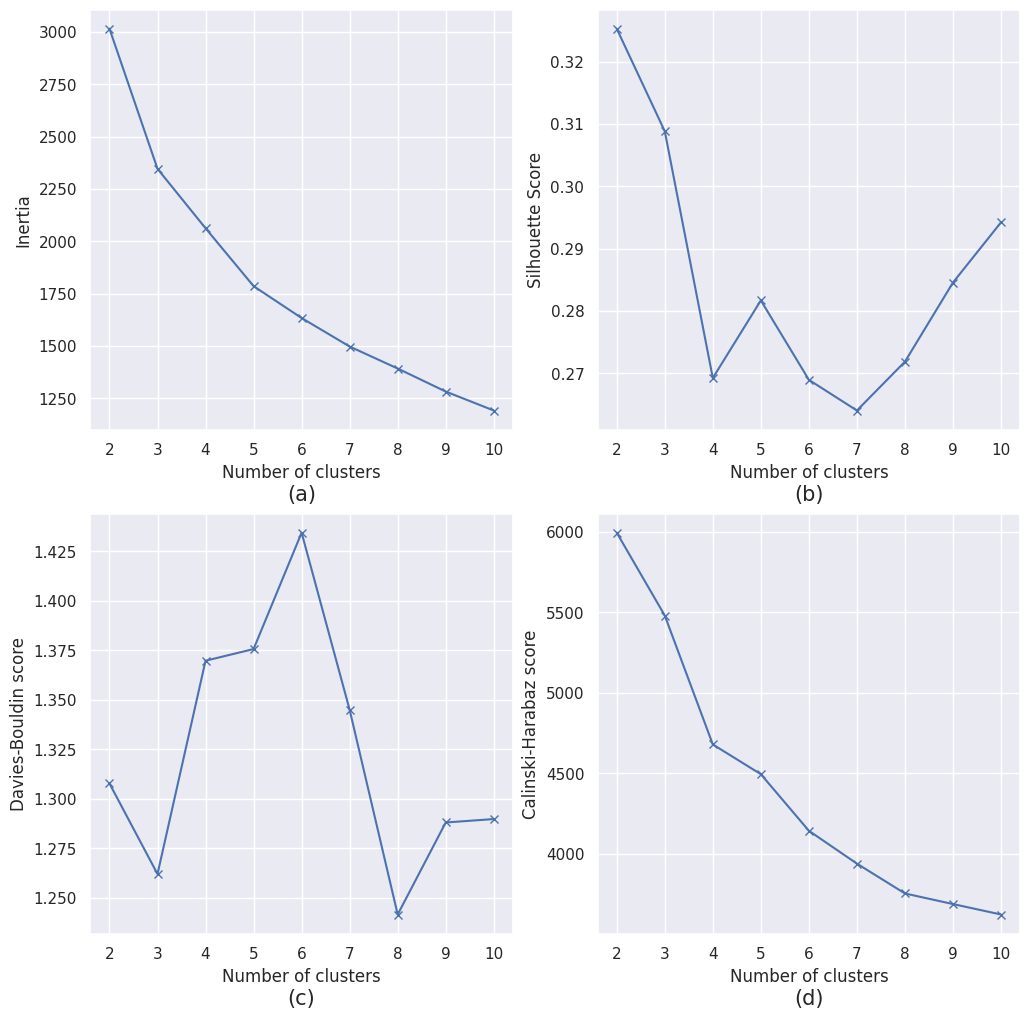

In [31]:
figure, axis = plt.subplots(2, 2, figsize= (12,12))

axis[0,0].plot(K, inertias, 'bx-')
axis[0,0].set_xlabel('Number of clusters')
axis[0,0].set_ylabel('Inertia')
axis[0,0].text(0.5,-0.17, "(a)", size=15, ha="center", transform=axis[0,0].transAxes)

axis[0,1].plot(K, km_silhouette, 'bx-')
axis[0,1].set_xlabel('Number of clusters')
axis[0,1].set_ylabel('Silhouette Score')
axis[0,1].text(0.5,-0.17, "(b)", size=15, ha="center", transform=axis[0,1].transAxes)

axis[1,0].plot(K, db_score, 'bx-')
axis[1,0].set_xlabel('Number of clusters')
axis[1,0].set_ylabel('Davies-Bouldin score')
axis[1,0].text(0.5,-0.17, "(c)", size=15, ha="center", transform=axis[1,0].transAxes)

axis[1,1].plot(K, ch_score, 'bx-')
axis[1,1].set_xlabel('Number of clusters')
axis[1,1].set_ylabel('Calinski-Harabaz score')
axis[1,1].text(0.5,-0.17, "(d)", size=15, ha="center", transform=axis[1,1].transAxes)
plt.show()

In [32]:
kmeans = KMeans(n_clusters=3, init= 'k-means++', n_init= 10)
kmeans.fit(oyster_features)
kmeans_labels = kmeans.predict(oyster_features)
kmeans_dbl, kmeans_sil, kmeans_ch = cluster_metrics(kmeans_labels, oyster_features)
X['Kmeans Patterns'] = kmeans_labels

In [33]:
neigh = NearestNeighbors(n_neighbors=20)
nbrs = neigh.fit(oyster_features)
distances, indices = nbrs.kneighbors(oyster_features)

distances1 = np.sort(distances, axis=0)
distances1 = distances1[:,1]
#plt.plot(distances)
#plt.xlabel('Distances')
#plt.ylabel('Epsilon')
#plt.show()

In [34]:
dbscan = DBSCAN(eps= 0.2 , min_samples=20)
dbscan_labels = dbscan.fit_predict(oyster_features)
dbscan_dbl, dbscan_sil, dbscan_ch = cluster_metrics(dbscan_labels, oyster_features)
X['DBSCAN Patterns'] = dbscan_labels

In [35]:
dbscan_df= pd.DataFrame(dbscan_labels, columns=['labels'])
dbscan_colors = len(dbscan_df.value_counts())
dbscan_colors

7

In [36]:
ward = AgglomerativeClustering(n_clusters=3, linkage= 'ward')
ward_labels = ward.fit_predict(oyster_features)
ward_dbl, ward_sil, ward_ch = cluster_metrics(ward_labels, oyster_features)
X['Ward Patterns'] = ward_labels

In [37]:
SC = SpectralClustering(n_clusters=3, n_init= 10)
SC_labels = SC.fit_predict(oyster_features)
SC_dbl, SC_sil, SC_ch = cluster_metrics(SC_labels, oyster_features)
X['Spectral Clustering Patterns'] = SC_labels

In [38]:
AP = AffinityPropagation()
AP.fit(oyster_features)
AP_labels = AP.predict(oyster_features)
AP_dbl, AP_sil, AP_ch = cluster_metrics(AP_labels, oyster_features)
X['Affinity Propagation Patterns'] = AP_labels

In [39]:
df_AP = pd.DataFrame(AP_labels, columns= ['labels'])
AP_colors = len(df_AP['labels'].value_counts())
AP_colors

225

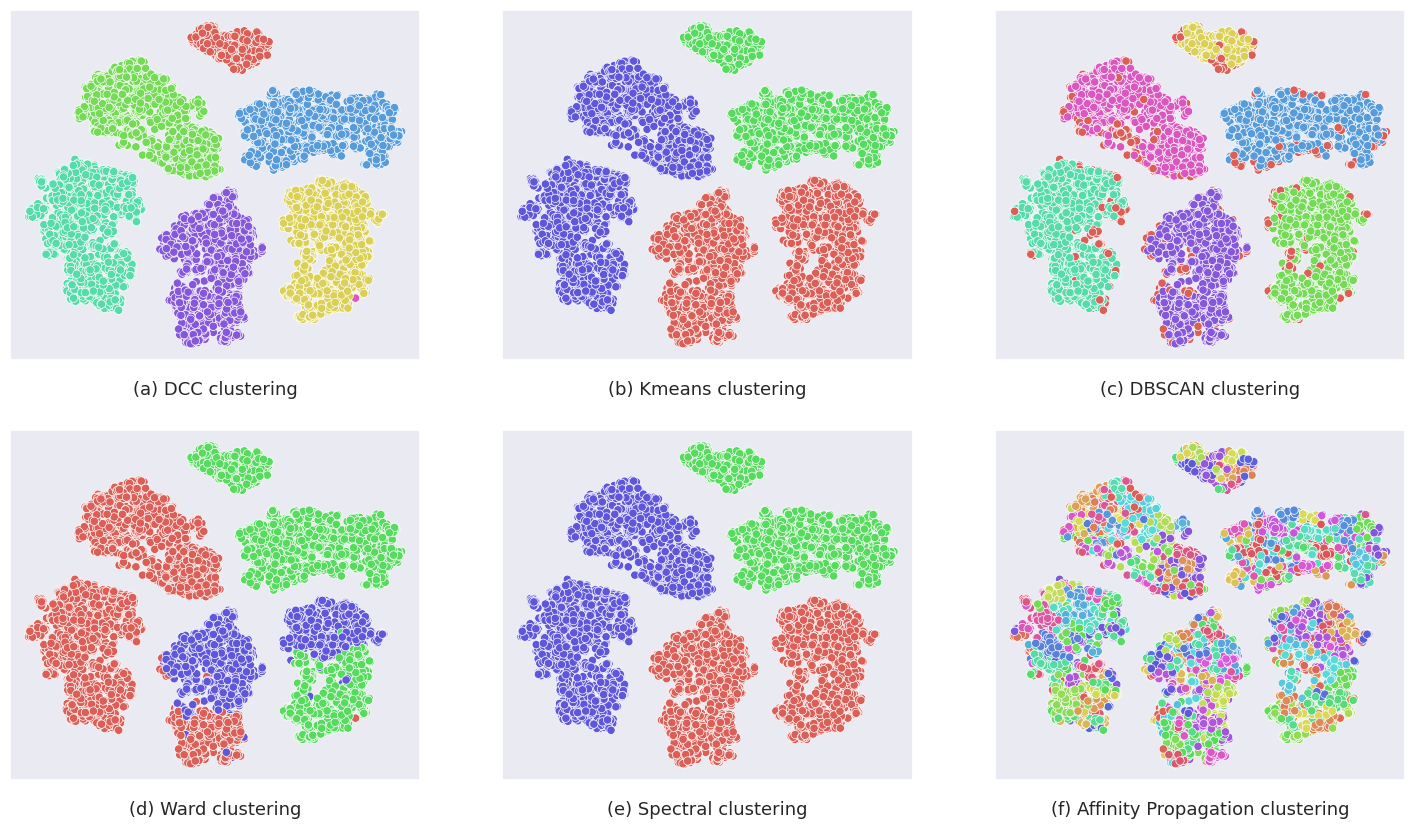

In [66]:
figure, axis = plt.subplots(2, 3, figsize= (18,10))
g1 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="DCC Patterns",
    palette=sns.color_palette("hls", 7),
    data=X,
    legend= 'full',
    ax=axis[0,0]
)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set(xticks=[])
g1.set(yticks=[])
g1.get_legend().remove()
axis[0,0].text(0.5,-0.10, "(a) DCC clustering", size=13, ha="center", transform=axis[0,0].transAxes)

g2 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Kmeans Patterns",
    palette=sns.color_palette("hls", 3),
    data=X,
    legend= 'full',
    ax=axis[0,1]
)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set(xticks=[])
g2.set(yticks=[])
g2.get_legend().remove()
axis[0,1].text(0.5,-0.10, "(b) Kmeans clustering", size=13, ha="center", transform=axis[0,1].transAxes)

g3 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="DBSCAN Patterns",
    palette=sns.color_palette("hls", dbscan_colors),
    data=X,
    legend= 'full',
    ax=axis[0,2]
)
g3.set(xlabel=None)
g3.set(ylabel=None)
g3.set(xticks=[])
g3.set(yticks=[])
g3.get_legend().remove()
axis[0,2].text(0.5,-0.10, "(c) DBSCAN clustering", size=13, ha="center", transform=axis[0,2].transAxes)

g4 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Ward Patterns",
    palette=sns.color_palette("hls", 3),
    data=X,
    legend= 'full',
    ax=axis[1,0]
)
g4.set(xlabel=None)
g4.set(ylabel=None)
g4.set(xticks=[])
g4.set(yticks=[])
g4.get_legend().remove()
axis[1,0].text(0.5,-0.10, "(d) Ward clustering", size=13, ha="center", transform=axis[1,0].transAxes)

g5 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Spectral Clustering Patterns",
    palette=sns.color_palette("hls", 3),
    data=X,
    legend= 'full',
    ax=axis[1,1]
)
g5.set(xlabel=None)
g5.set(ylabel=None)
g5.set(xticks=[])
g5.set(yticks=[])
g5.get_legend().remove()
axis[1,1].text(0.5,-0.10, "(e) Spectral clustering", size=13, ha="center", transform=axis[1,1].transAxes)

g6 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Affinity Propagation Patterns",
    palette=sns.color_palette("hls", AP_colors),
    data=X,
    legend= 'full',
    ax=axis[1,2]
)
g6.set(xlabel=None)
g6.set(ylabel=None)
g6.set(xticks=[])
g6.set(yticks=[])
g6.get_legend().remove()
axis[1,2].text(0.5,-0.10, "(f) Affinity Propagation clustering", size=13, ha="center", transform=axis[1,2].transAxes)
plt.savefig("tsne.svg")

In [41]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Clustering Algorithm", "Davies–Bouldin Score", "Silhouette Score", "Calinski-Harabasz Score"]
x.add_row(["KMeans", kmeans_dbl, kmeans_sil, kmeans_ch])
x.add_row(["DBSCAN", dbscan_dbl, dbscan_sil, dbscan_ch])
x.add_row(["Ward", ward_dbl, ward_sil, ward_ch])
x.add_row(["Affinity Propagation", AP_dbl, AP_sil, AP_ch])
x.add_row(["Spectral Clustering", SC_dbl, SC_sil, SC_ch])
x.add_row(["DCC", DCC_dbl, DCC_sil, DCC_ch])

print(x)

+----------------------+----------------------+------------------+-------------------------+
| Clustering Algorithm | Davies–Bouldin Score | Silhouette Score | Calinski-Harabasz Score |
+----------------------+----------------------+------------------+-------------------------+
|        KMeans        |  1.261889337382938   |    0.30881712    |     5480.07958187311    |
|        DBSCAN        |  1.9271627244725562  |    0.22019206    |    2375.6415686198993   |
|         Ward         |  1.335776713292818   |    0.2412741     |    4393.009324858443    |
| Affinity Propagation |   1.45269111669161   |    0.14043102    |    608.1175381088644    |
| Spectral Clustering  |  1.261889337382938   |    0.30881712    |     5480.07958187311    |
|         DCC          | 0.33872836964502817  |    0.71580803    |    253173.03375719182   |
+----------------------+----------------------+------------------+-------------------------+


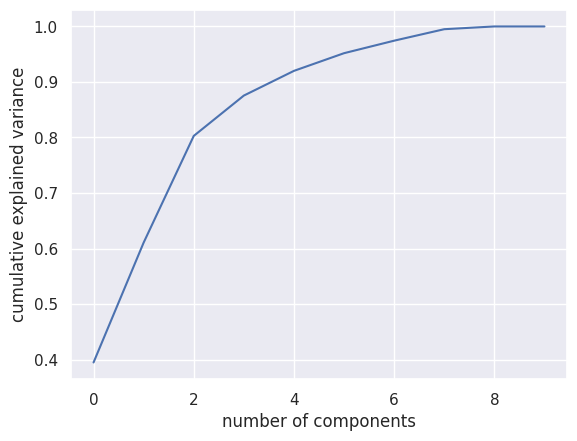

In [42]:
pca = PCA().fit(clean_oyster.values)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [43]:
pca = PCA(n_components=6, random_state= 0)
pca_results = pca.fit_transform(clean_oyster.values)
pca_oyster_features = pca_results

In [44]:
distortions = []
inertias = []
km_silhouette = []
db_score = []
ch_score = []
mapping = {}
K = range(2,11)

for k in K:
    #Building and fitting the model
    km = KMeans(n_clusters=k).fit(pca_oyster_features)
    preds = km.predict(pca_oyster_features)

    inertias.append(km.inertia_)

    mapping[k] = km.inertia_

    silhouette = metrics.silhouette_score(pca_oyster_features,preds)
    km_silhouette.append(silhouette)

    db = metrics.davies_bouldin_score(pca_oyster_features,preds)
    db_score.append(db)

    ch = metrics.calinski_harabasz_score(pca_oyster_features,preds)
    ch_score.append(ch)

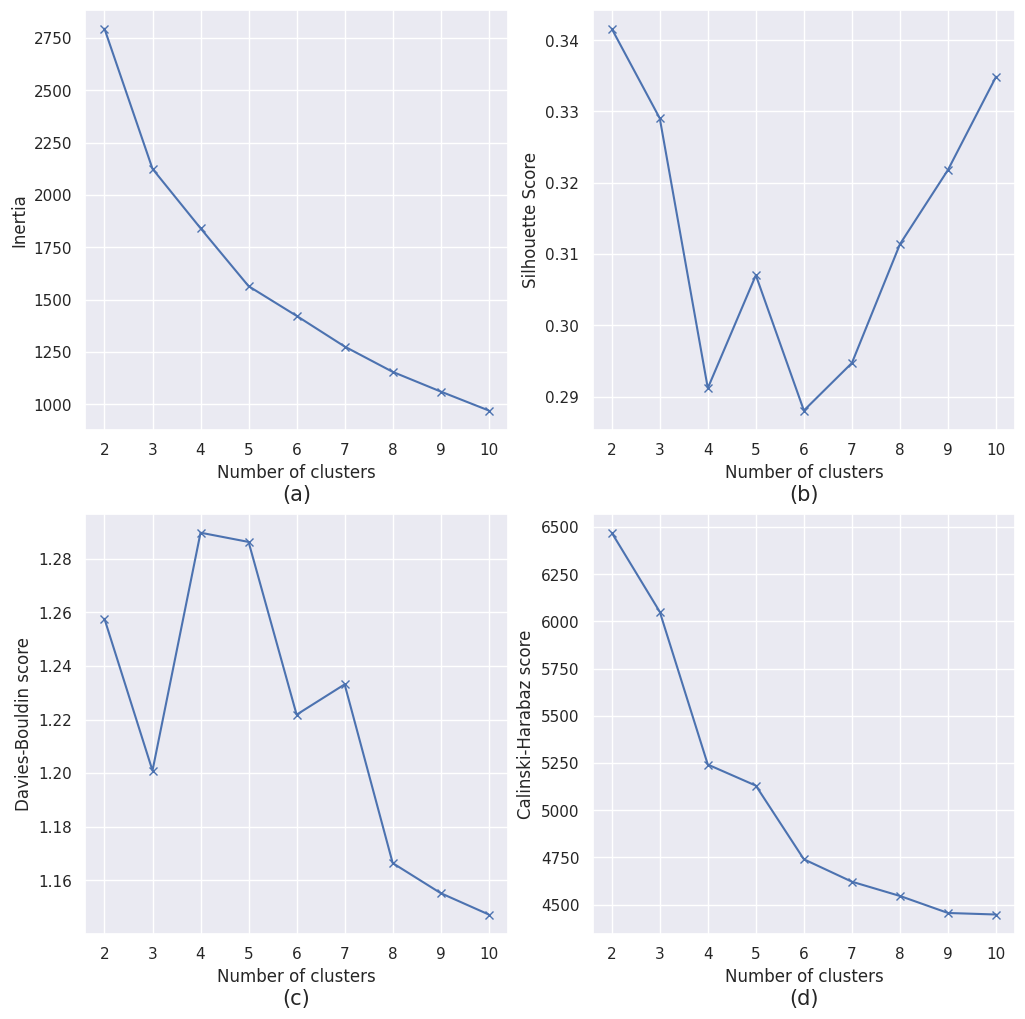

In [45]:
figure, axis = plt.subplots(2, 2, figsize= (12,12))

axis[0,0].plot(K, inertias, 'bx-')
axis[0,0].set_xlabel('Number of clusters')
axis[0,0].set_ylabel('Inertia')
axis[0,0].text(0.5,-0.17, "(a)", size=15, ha="center", transform=axis[0,0].transAxes)

axis[0,1].plot(K, km_silhouette, 'bx-')
axis[0,1].set_xlabel('Number of clusters')
axis[0,1].set_ylabel('Silhouette Score')
axis[0,1].text(0.5,-0.17, "(b)", size=15, ha="center", transform=axis[0,1].transAxes)

axis[1,0].plot(K, db_score, 'bx-')
axis[1,0].set_xlabel('Number of clusters')
axis[1,0].set_ylabel('Davies-Bouldin score')
axis[1,0].text(0.5,-0.17, "(c)", size=15, ha="center", transform=axis[1,0].transAxes)

axis[1,1].plot(K, ch_score, 'bx-')
axis[1,1].set_xlabel('Number of clusters')
axis[1,1].set_ylabel('Calinski-Harabaz score')
axis[1,1].text(0.5,-0.17, "(d)", size=15, ha="center", transform=axis[1,1].transAxes)
plt.show()

In [46]:
kmeans = KMeans(n_clusters=3, init= 'k-means++', n_init= 10)
kmeans.fit(pca_oyster_features)
kmeans_labels = kmeans.predict(pca_oyster_features)
kmeans_dbl2, kmeans_sil2, kmeans_ch2 = cluster_metrics(kmeans_labels, pca_oyster_features)
X['Kmeans Patterns 2'] = kmeans_labels

In [47]:
neigh = NearestNeighbors(n_neighbors=12)
nbrs = neigh.fit(pca_oyster_features)
distances, indices = nbrs.kneighbors(pca_oyster_features)

distances2 = np.sort(distances, axis=0)
distances2 = distances2[:,1]
#plt.plot(distances)
#plt.xlabel('Distances')
#plt.ylabel('Epsilon')
#plt.show()

In [48]:
dbscan = DBSCAN(eps= 0.15 , min_samples=12)
dbscan_labels = dbscan.fit_predict(pca_oyster_features)
dbscan_dbl, dbscan_sil, dbscan_ch = cluster_metrics(dbscan_labels, pca_oyster_features)
X['DBSCAN Patterns'] = dbscan_labels

In [49]:
dbscan_df= pd.DataFrame(dbscan_labels, columns=['labels'])
dbscan_colors = len(dbscan_df.value_counts())
dbscan_colors

7

In [50]:
ward = AgglomerativeClustering(n_clusters=3, linkage= 'ward')
ward_labels = ward.fit_predict(pca_oyster_features)
ward_dbl2, ward_sil2, ward_ch2 = cluster_metrics(ward_labels, pca_oyster_features)
X['Ward Patterns 2'] = ward_labels

In [51]:
SC = SpectralClustering(n_clusters=3, n_init= 10)
SC_labels = SC.fit_predict(pca_oyster_features)
SC_dbl2, SC_sil2, SC_ch2 = cluster_metrics(SC_labels, pca_oyster_features)
X['Spectral Clustering Patterns 2'] = SC_labels

In [52]:
AP = AffinityPropagation()
AP.fit(pca_oyster_features)
AP_labels = AP.predict(pca_oyster_features)
AP_dbl, AP_sil, AP_ch = cluster_metrics(AP_labels, pca_oyster_features)
X['Affinity Propagation Patterns'] = AP_labels

In [54]:
df_AP = pd.DataFrame(AP_labels, columns= ['labels'])
AP_colors = len(df_AP['labels'].value_counts())
AP_colors

197

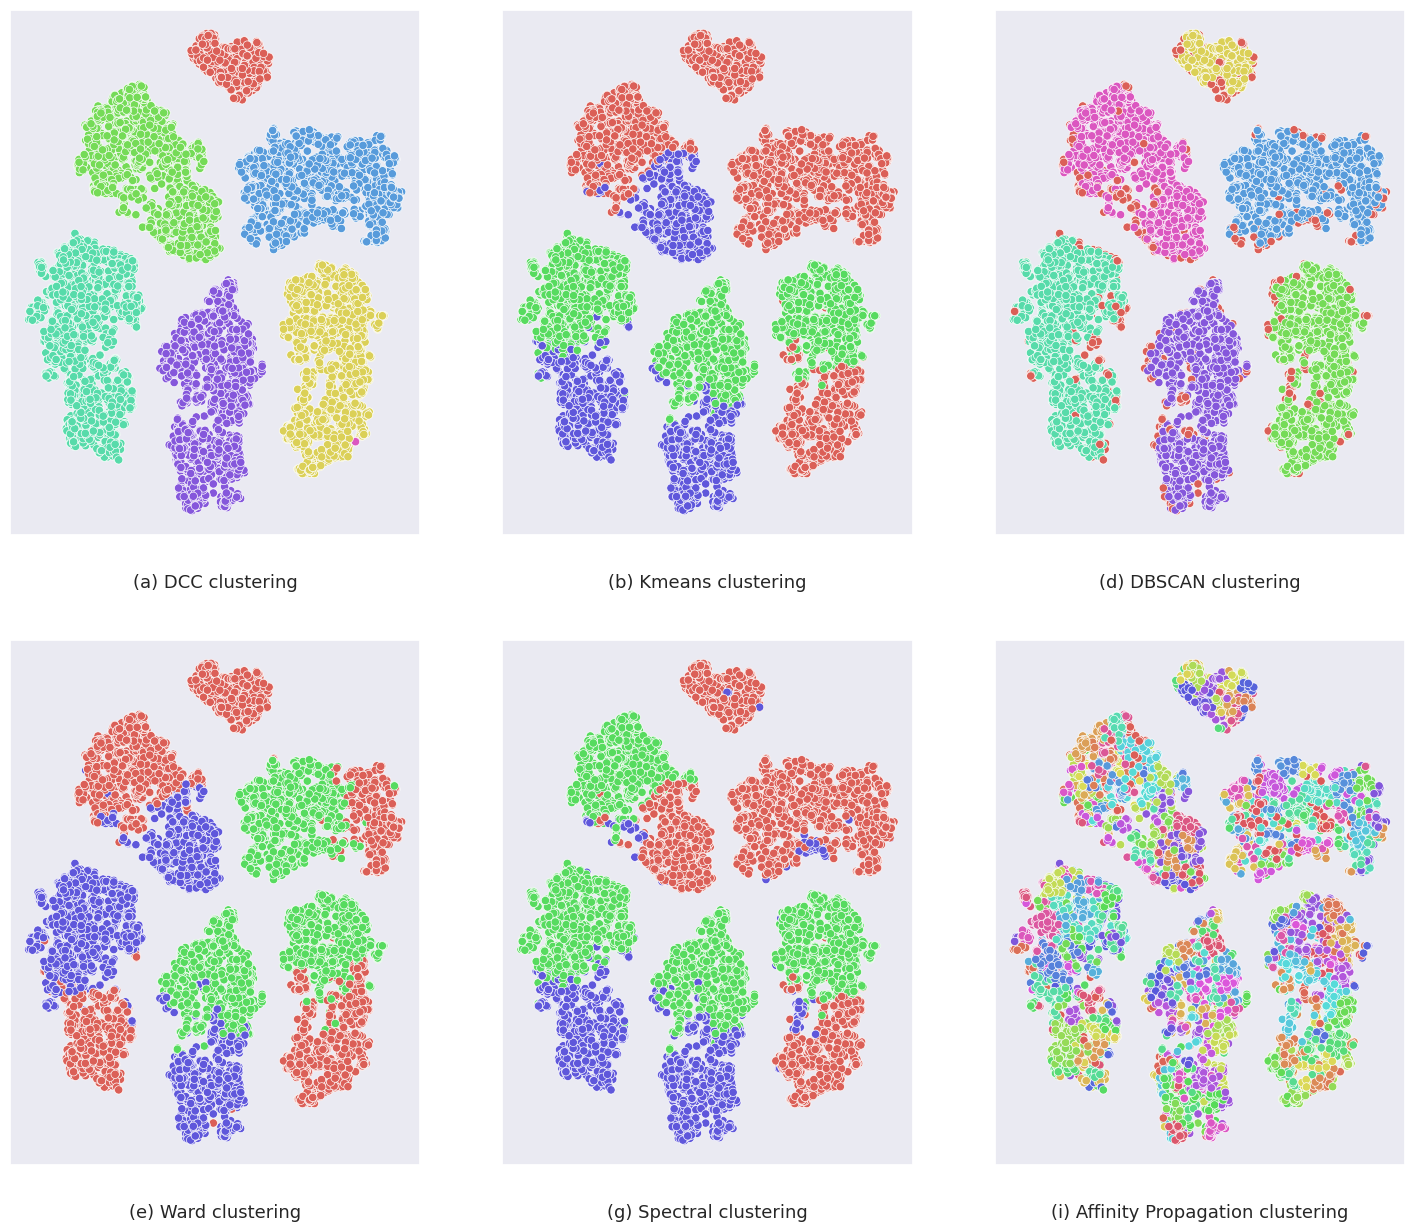

In [65]:
figure, axis = plt.subplots(2, 3, figsize= (18,15))
g1 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="DCC Patterns",
    palette=sns.color_palette("hls", 7),
    data=X,
    legend= 'full',
    ax=axis[0,0]
)
g1.set(xlabel=None)
g1.set(ylabel=None)
g1.set(xticks=[])
g1.set(yticks=[])
g1.get_legend().remove()
axis[0,0].text(0.5,-0.10, "(a) DCC clustering", size=13, ha="center", transform=axis[0,0].transAxes)

g2 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Kmeans Patterns 2",
    palette=sns.color_palette("hls", 3),
    data=X,
    legend= 'full',
    ax=axis[0,1]
)
g2.set(xlabel=None)
g2.set(ylabel=None)
g2.set(xticks=[])
g2.set(yticks=[])
g2.get_legend().remove()
axis[0,1].text(0.5,-0.10, "(b) Kmeans clustering", size=13, ha="center", transform=axis[0,1].transAxes)


g4 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="DBSCAN Patterns",
    palette=sns.color_palette("hls", dbscan_colors),
    data=X,
    legend= 'full',
    ax=axis[0,2]
)
g4.set(xlabel=None)
g4.set(ylabel=None)
g4.set(xticks=[])
g4.set(yticks=[])
g4.get_legend().remove()
axis[0,2].text(0.5,-0.10, "(d) DBSCAN clustering", size=13, ha="center", transform=axis[0,2].transAxes)

g5 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Ward Patterns 2",
    palette=sns.color_palette("hls", 3),
    data=X,
    legend= 'full',
    ax=axis[1,0]
)
g5.set(xlabel=None)
g5.set(ylabel=None)
g5.set(xticks=[])
g5.set(yticks=[])
g5.get_legend().remove()
axis[1,0].text(0.5,-0.10, "(e) Ward clustering", size=13, ha="center", transform=axis[1,0].transAxes)


g7 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Spectral Clustering Patterns 2",
    palette=sns.color_palette("hls", 3),
    data=X,
    legend= 'full',
    ax=axis[1,1]
)
g7.set(xlabel=None)
g7.set(ylabel=None)
g7.set(xticks=[])
g7.set(yticks=[])
g7.get_legend().remove()
axis[1,1].text(0.5,-0.10, "(g) Spectral clustering", size=13, ha="center", transform=axis[1,1].transAxes)


g9 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Affinity Propagation Patterns",
    palette=sns.color_palette("hls", AP_colors),
    data=X,
    legend= 'full',
    ax=axis[1,2]
)
g9.set(xlabel=None)
g9.set(ylabel=None)
g9.set(xticks=[])
g9.set(yticks=[])
g9.get_legend().remove()
axis[1,2].text(0.5,-0.10, "(i) Affinity Propagation clustering", size=13, ha="center", transform=axis[1,2].transAxes)
plt.savefig("pca.svg")

In [56]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Clustering Algorithm", "Davies–Bouldin Score", "Silhouette Score", "Calinski-Harabasz Score"]
x.add_row(["KMeans(3)", kmeans_dbl2, kmeans_sil2, kmeans_ch2])
x.add_row(["DBSCAN", dbscan_dbl, dbscan_sil, dbscan_ch])
x.add_row(["Ward(3)", ward_dbl2, ward_sil2, ward_ch2])
x.add_row(["Affinity Propagation", AP_dbl, AP_sil, AP_ch])
x.add_row(["Spectral Clustering(3)", SC_dbl2, SC_sil2, SC_ch2])
x.add_row(["DCC", DCC_dbl, DCC_sil, DCC_ch])

print(x)

+------------------------+----------------------+------------------+-------------------------+
|  Clustering Algorithm  | Davies–Bouldin Score | Silhouette Score | Calinski-Harabasz Score |
+------------------------+----------------------+------------------+-------------------------+
|       KMeans(3)        |  1.1471737111529738  |    0.33485153    |    4447.585160308148    |
|         DBSCAN         |  1.957058417413555   |    0.2593234     |    2814.225014161411    |
|        Ward(3)         |  1.154602671724538   |    0.31241682    |    4107.269596323597    |
|  Affinity Propagation  |  1.2566826534533597  |    0.18140441    |    1038.4144767024945   |
| Spectral Clustering(3) |  1.334960732812663   |    0.29375544    |    3625.6880511334734   |
|          DCC           | 0.33872836964502817  |    0.71580803    |    253173.03375719182   |
+------------------------+----------------------+------------------+-------------------------+
